# Scotland-wide Food Hygiene Data Analysis

## Setup

Import the SQLite database for analysis. The database contains business names, post codes, coordinates and hygiene rating. To update the database, use the `data/fetch_master_data.py` file to update the database from the XML source on the food ratings website: https://ratings.food.gov.uk/open-data

In this case we will be using Highland data for local business insights. The food hygiene ratings have the following scheme in Scotland:

- **Pass**:  means they meet the legal requirements for food hygiene.
- **Improvement Requried**: means the business didn’t meet the legal requirements and needs to make improvements.
- **Exempt Premises** means the business has been inspected by a local authority food safety officer, met the pass criteria, but don’t meet the criteria to be part of the scheme.  These businesses are low-risk to people’s health in terms of food safety and you perhaps wouldn’t normally think of them as a food business – for example, newsagents, chemist shops or visitor centres selling tins of biscuits.
- **Awaiting Inspection**: means a new business or new business owner is waiting for an inspection.


Further information can be found at this link: https://www.foodstandards.gov.scot/consumers/food-safety/buying-food-eating-out/food-hygiene-information-scheme/about-the-food-hygiene-information-scheme

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from os import getcwd
import folium
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd



# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 9)

# Connect to the SQLite database
#Run fetch_data.py in the data directory to update the database from the FHIS website
home_path = getcwd()
#print(home_path)
conn = sqlite3.connect("/mnt/d/renfrewshire_business_insights/data/master_hygiene.db") #adjust path accordingly

## Overview of Data

Have a quick look at the data to understand the column types and structure.

In [2]:
#Initial scoping of the SQL database to confirm all is working well
df = pd.read_sql_query("SELECT * FROM establishments;", conn)
#print(df.head(10))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57059 entries, 0 to 57058
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FHRSID                      57059 non-null  object
 1   LocalAuthorityBusinessID    57059 non-null  object
 2   BusinessName                57059 non-null  object
 3   BusinessType                57059 non-null  object
 4   BusinessTypeID              57059 non-null  object
 5   AddressLine2                42040 non-null  object
 6   AddressLine3                33852 non-null  object
 7   PostCode                    57059 non-null  object
 8   RatingValue                 57059 non-null  object
 9   RatingKey                   57059 non-null  object
 10  RatingDate                  53948 non-null  object
 11  LocalAuthorityCode          57059 non-null  object
 12  LocalAuthorityName          57059 non-null  object
 13  LocalAuthorityWebSite       57059 non-null  ob

## Top 10 Business Types by Count

Look at the top 10 business categories by number registered in Scotland. We can generate a bar plot with the count of businesses and a pie chart to show their distribution.

                          BusinessType  Count
0              Restaurant/Cafe/Canteen  12320
1                    Retailers - other  10245
2              Other catering premises   6435
3               Takeaway/sandwich shop   6110
4  Hospitals/Childcare/Caring Premises   4354
5                    Pub/bar/nightclub   4027
6            School/college/university   3134
7    Hotel/bed & breakfast/guest house   3097
8                       Mobile caterer   2533
9                Manufacturers/packers   2010
0                               Others   2794


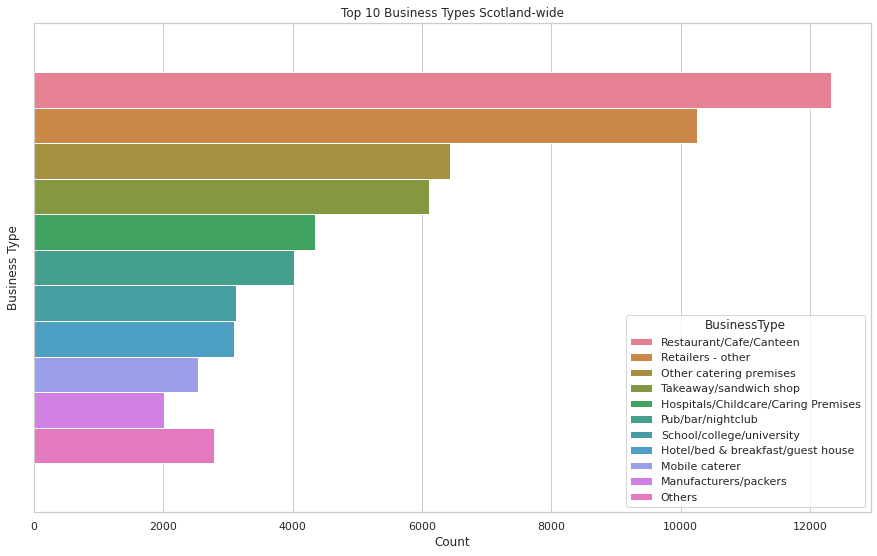

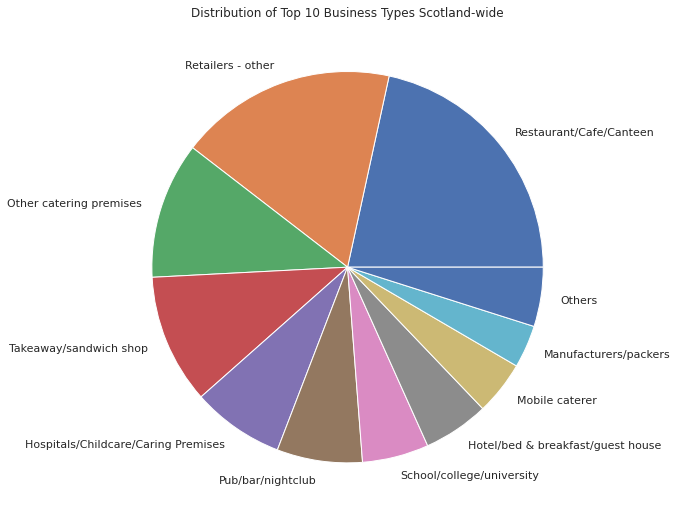

In [3]:
#Use SQL to read the database and write to a Pandas DataFrame
business_counts = pd.read_sql_query("""
SELECT BusinessType, COUNT(*) as Count
FROM establishments
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Manipulate the dataframe to produce an others category for below top 10
def topN(df, N, column):
    """A function that takes an ordered, counted, categorised dataframe and sums all categories
    for chosen column over >N to Others
    
    df - Pandas dataframe
    N - integer, top N categories
    column - str, column in df over which to sum other categories"""
    
    df2 = df[:N].copy()
    new_row = pd.DataFrame(data = {
    column : ['Others'],
    'Count' : [df['Count'][N:].sum()]
    })
    
    df = pd.concat([df2,new_row])
    return df

#the top 10
business_counts = topN(business_counts, 10, "BusinessType")
print(business_counts)

#Plotting
#print(business_counts)
sns.barplot(data=business_counts, x="Count", hue="BusinessType", legend = True)
plt.title("Top 10 Business Types Scotland-wide")
plt.xlabel("Count")
plt.ylabel("Business Type")
plt.show()

#Pie chart
# define Seaborn color palette to use
business_counts.plot.pie(y = "Count", labels = business_counts["BusinessType"], legend = False)
plt.title("Distribution of Top 10 Business Types Scotland-wide")
#plt.xlabel("Rating")
plt.ylabel("") #leave the ylabel empty
#plt.ylabel("Number of Establishments")
plt.show()



[Insert analysis here]

## Hygiene Score Distribution

We can group the businesses by hygiene rating score to get an idea of the proportion who have passed, who needs improvement and other circumstances.

            RatingValue  Count
0                  Pass  41803
1   Awaiting Inspection   9200
2  Improvement Required   3305
3                Exempt   2225
4     Pass and Eat Safe    526
Total counts is:  57059


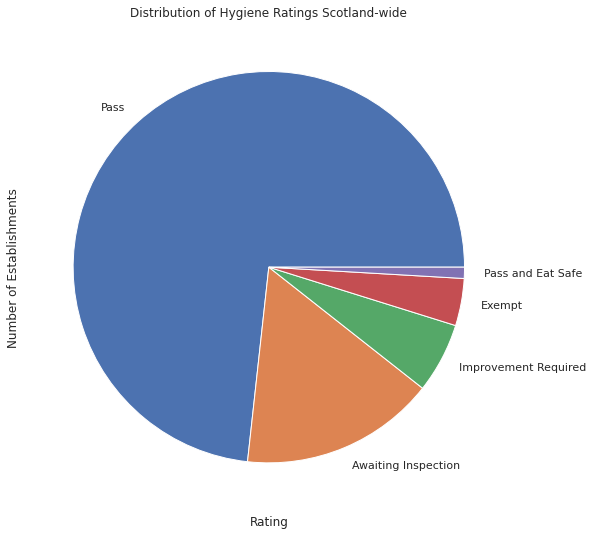

['Aberdeen City', 'Aberdeenshire', 'Angus', 'Argyll and Bute', 'Clackmannanshire', 'Comhairle nan Eilean Siar (Western Isles)', 'Dumfries and Galloway', 'Dundee City', 'East Ayrshire', 'East Dunbartonshire', 'East Lothian', 'East Renfrewshire', 'Edinburgh (City of)', 'Falkirk', 'Fife', 'Glasgow City', 'Highland', 'Inverclyde', 'Midlothian', 'Moray', 'North Ayrshire', 'North Lanarkshire', 'Orkney Islands', 'Perth and Kinross', 'Renfrewshire', 'Scottish Borders', 'Shetland Islands', 'South Ayrshire', 'South Lanarkshire', 'Stirling', 'West Dunbartonshire', 'West Lothian']


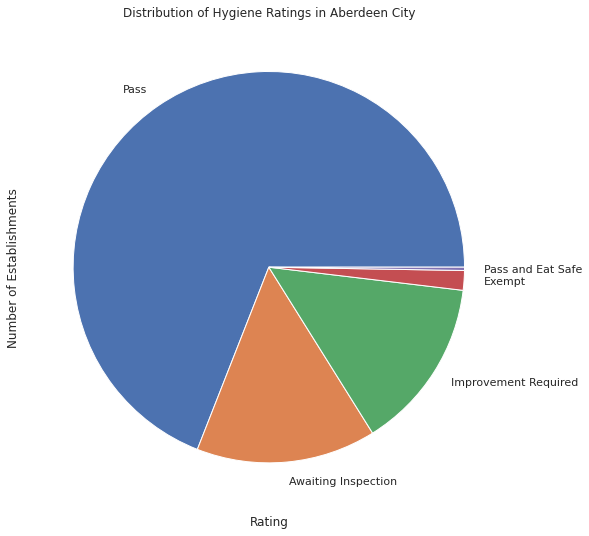

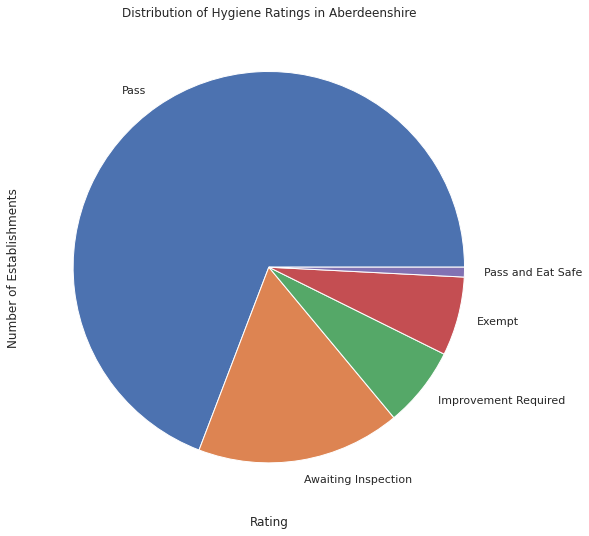

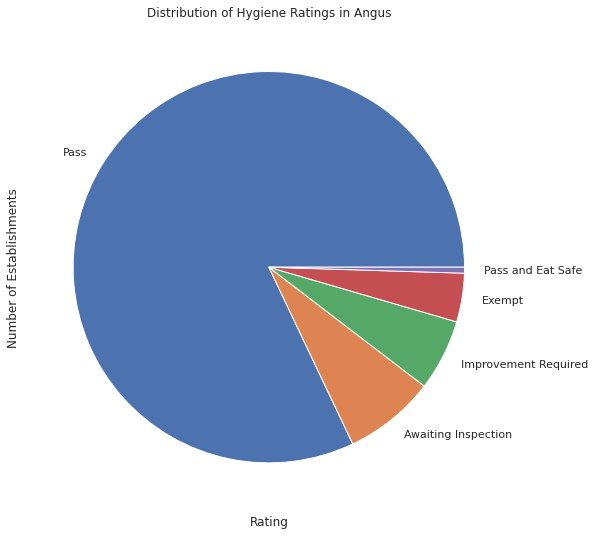

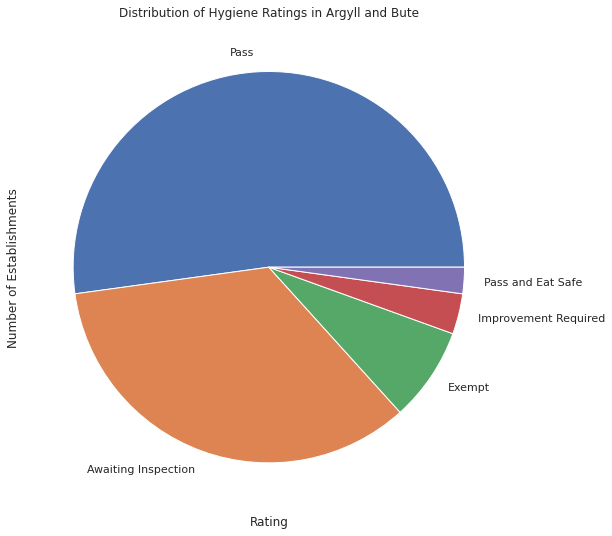

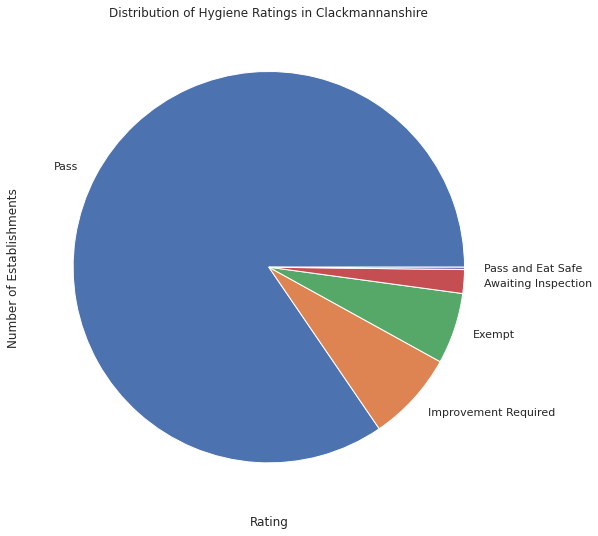

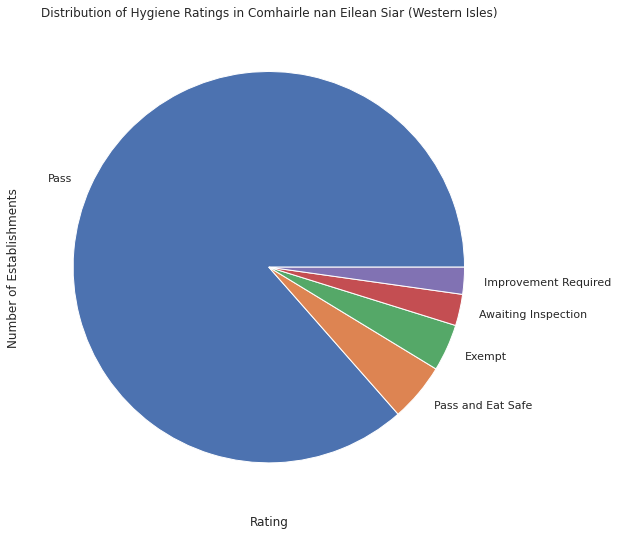

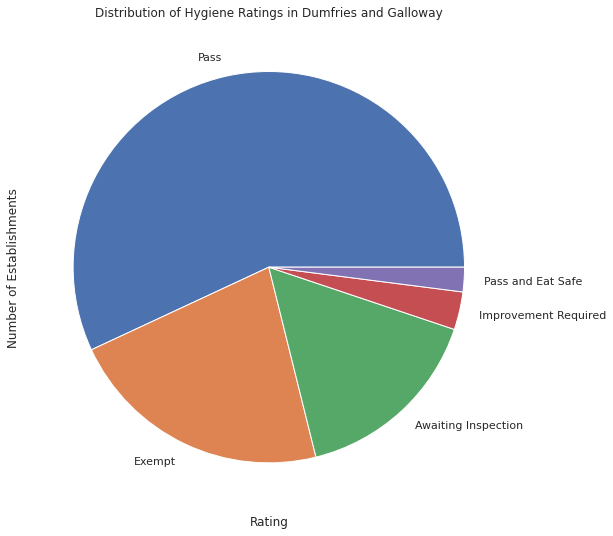

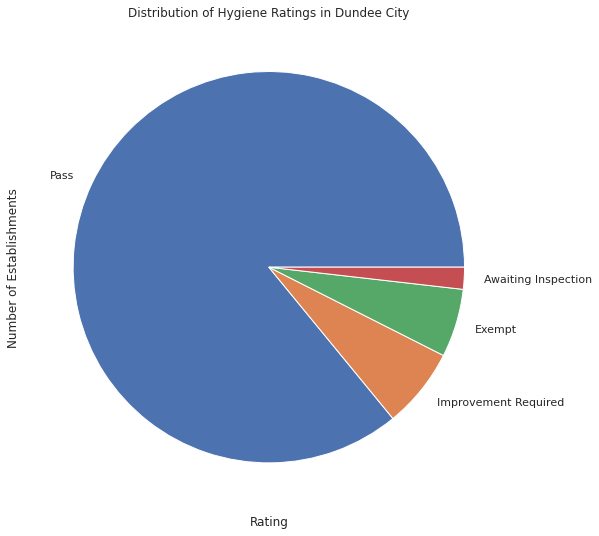

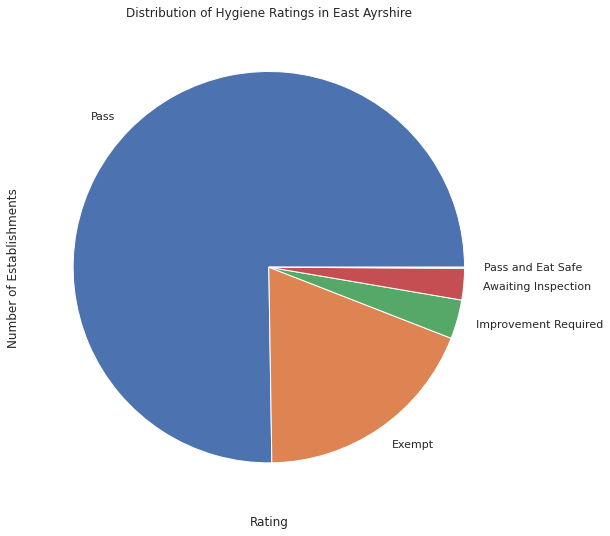

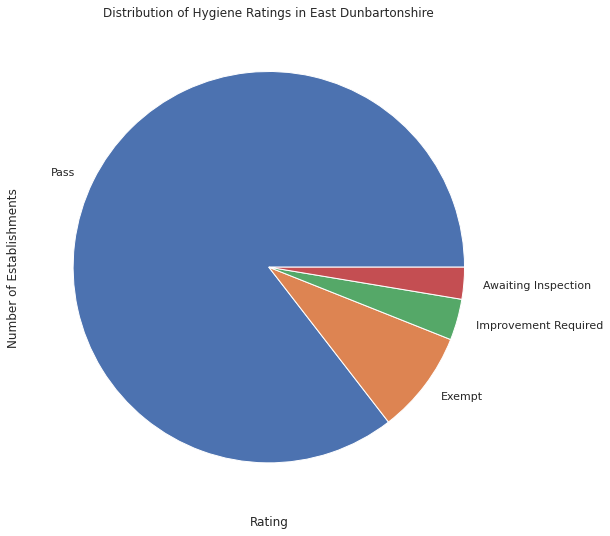

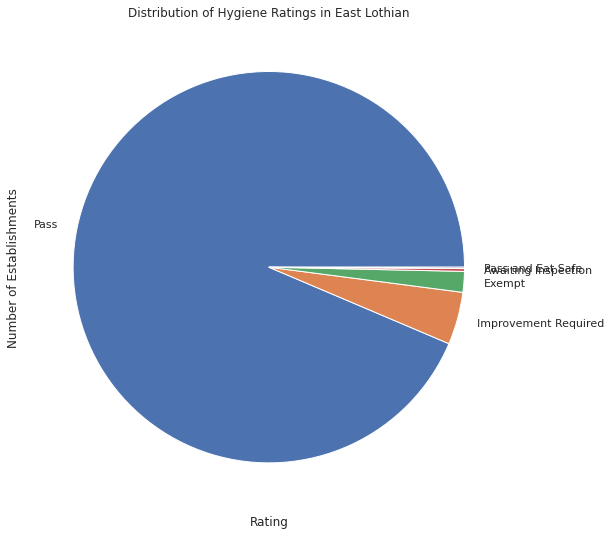

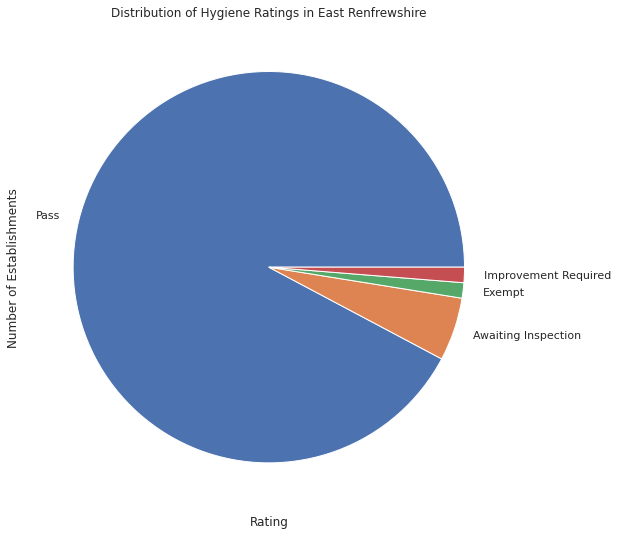

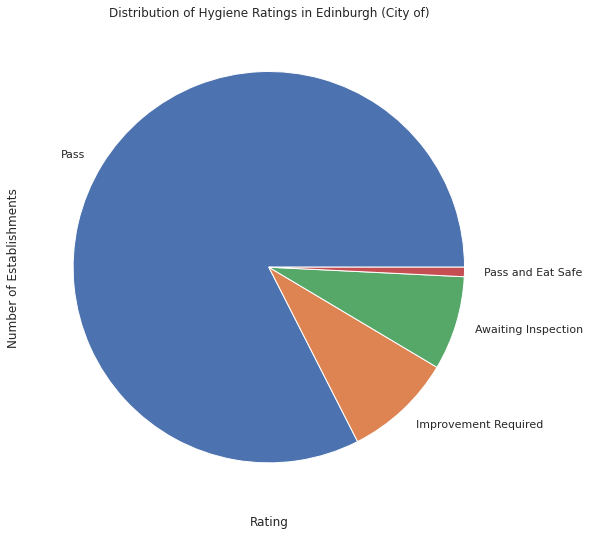

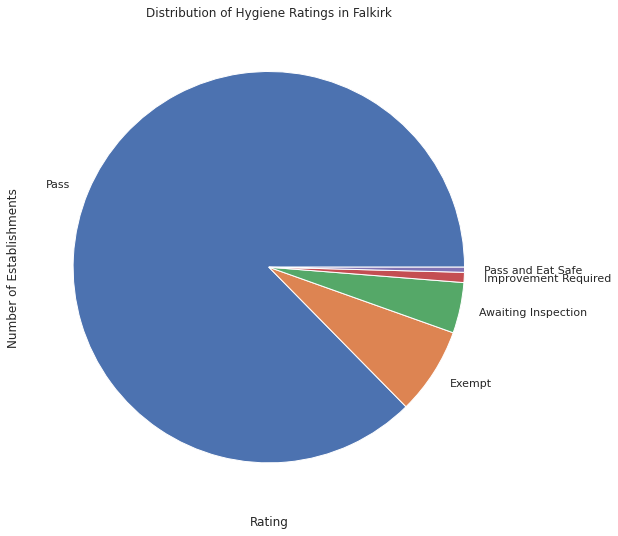

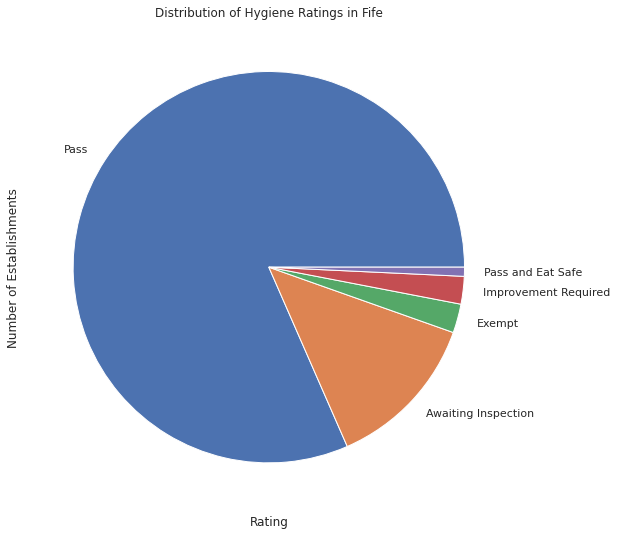

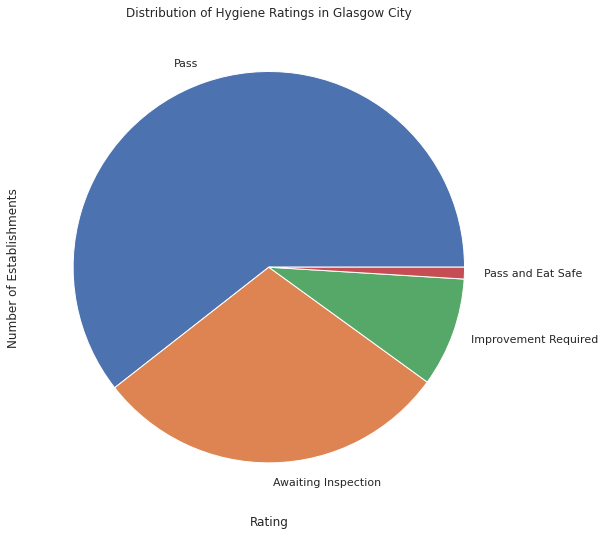

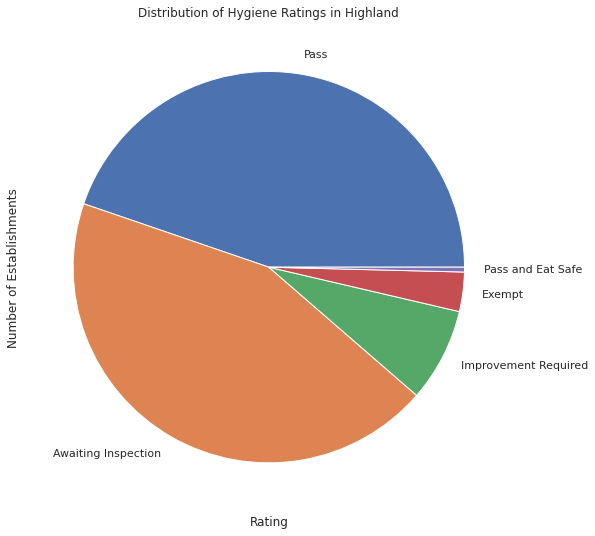

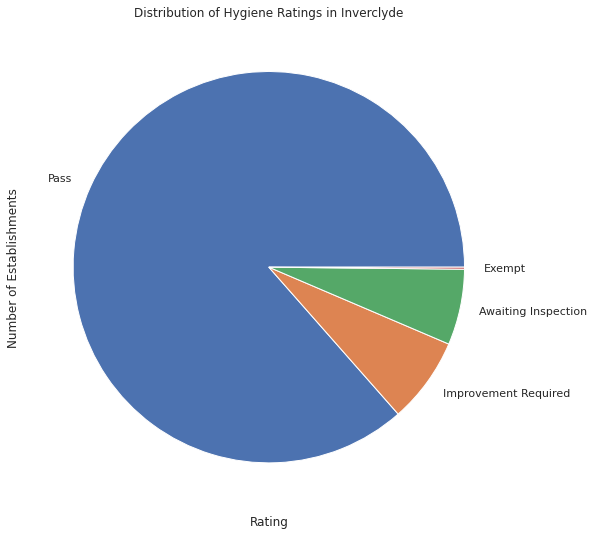

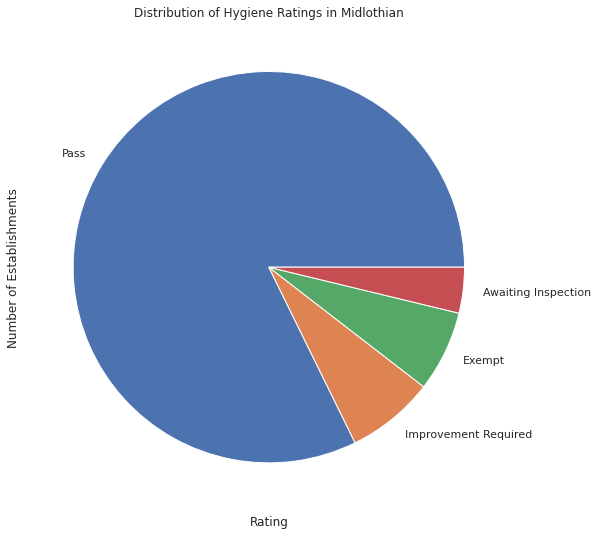

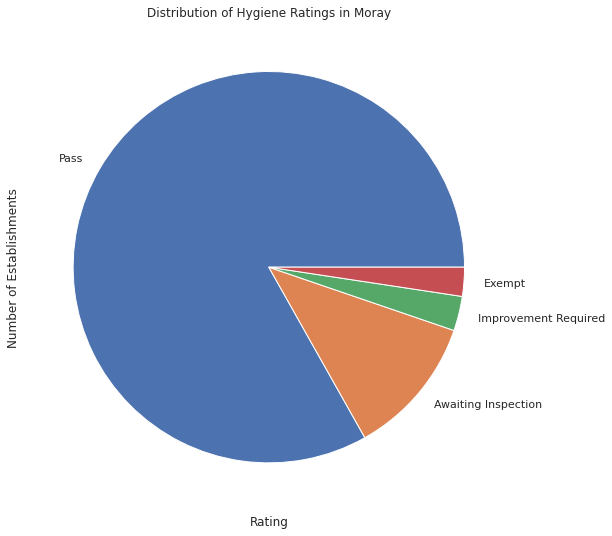

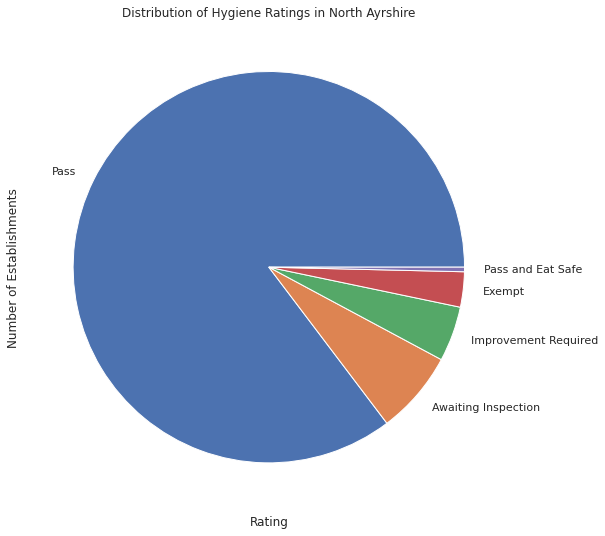

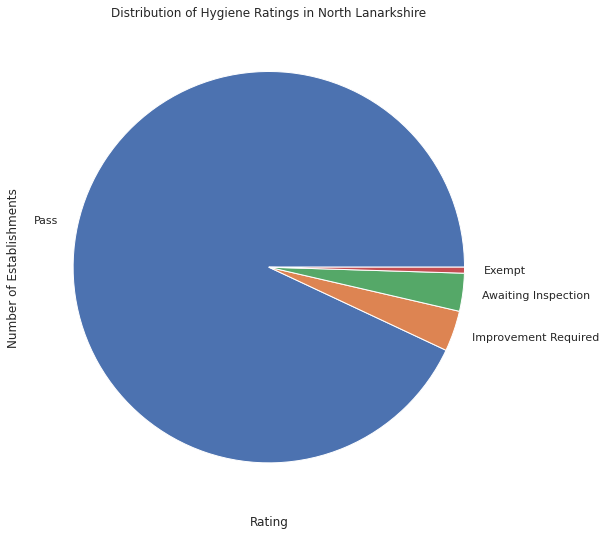

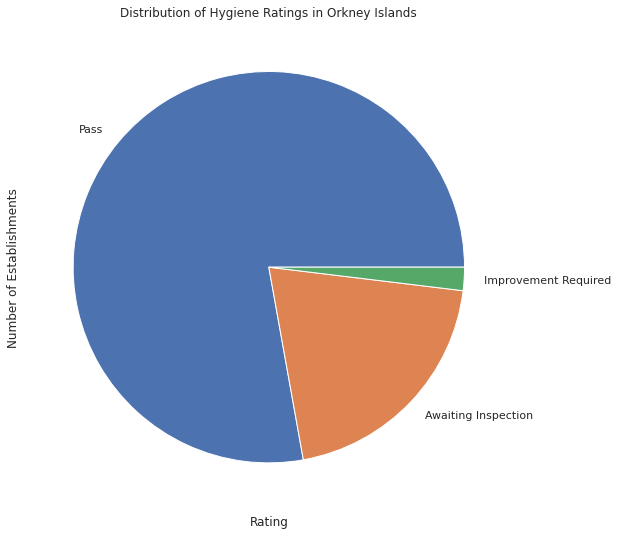

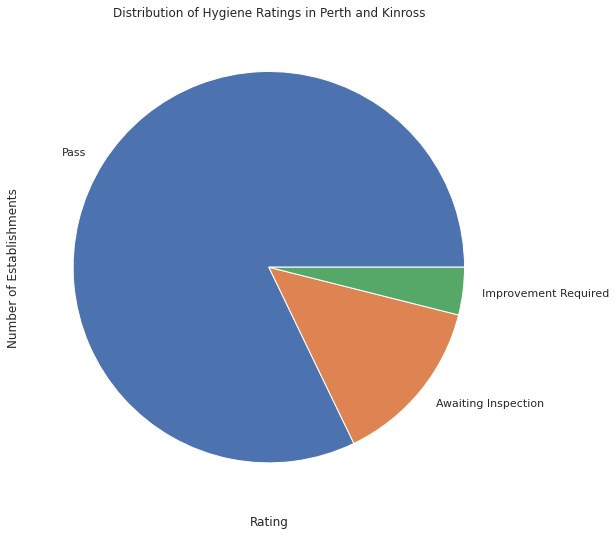

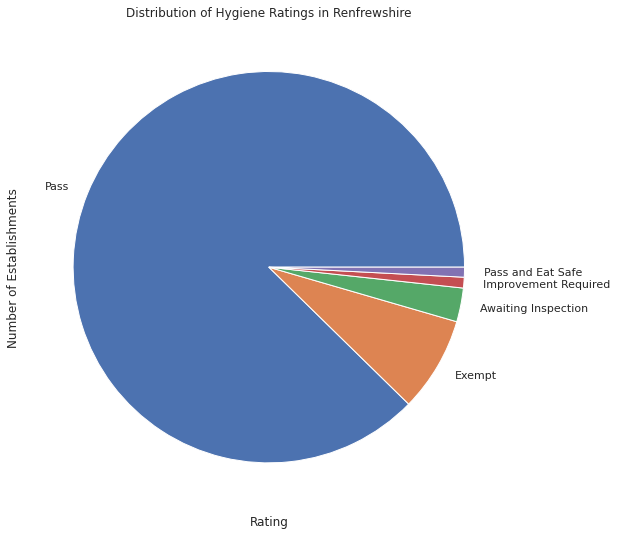

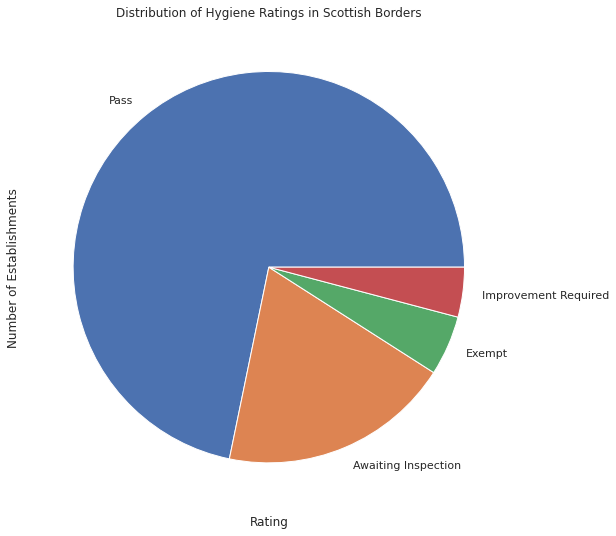

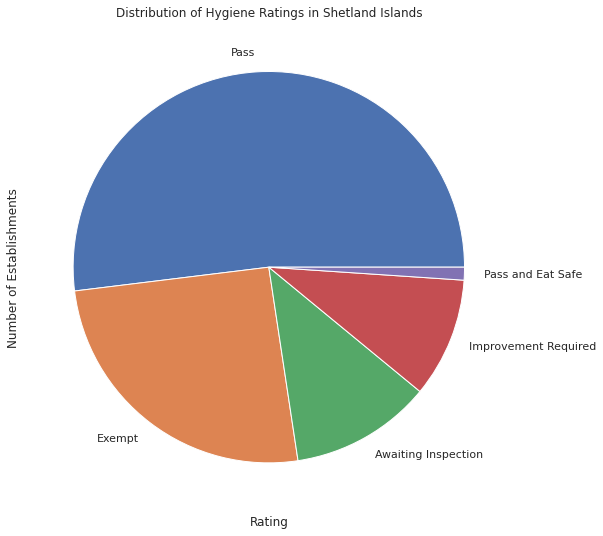

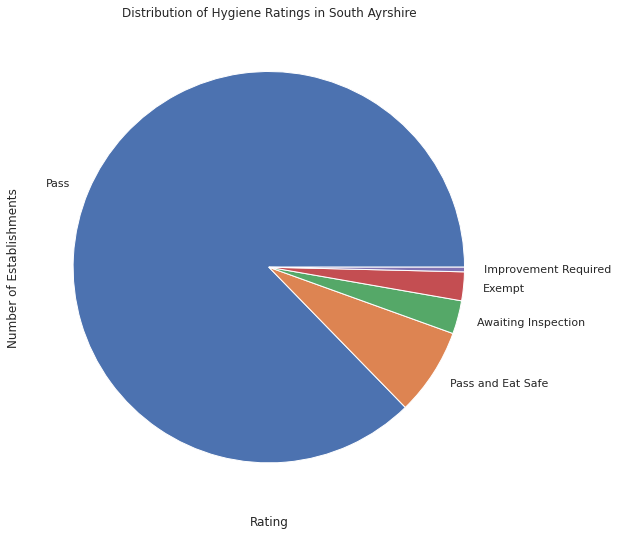

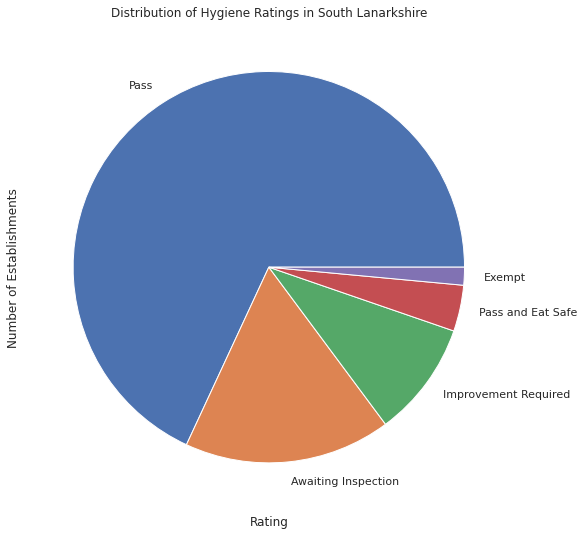

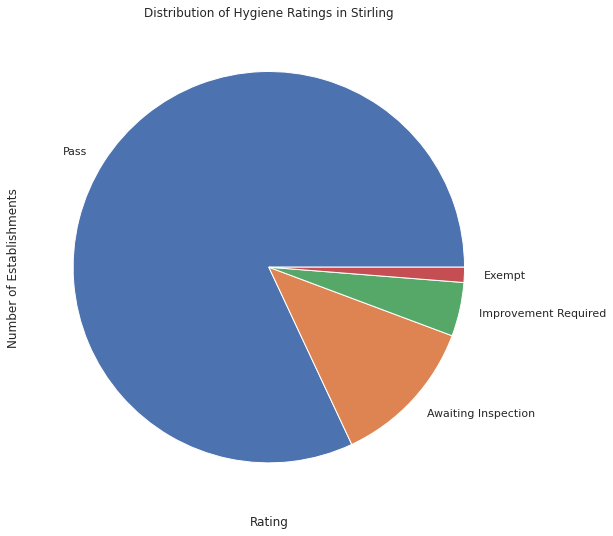

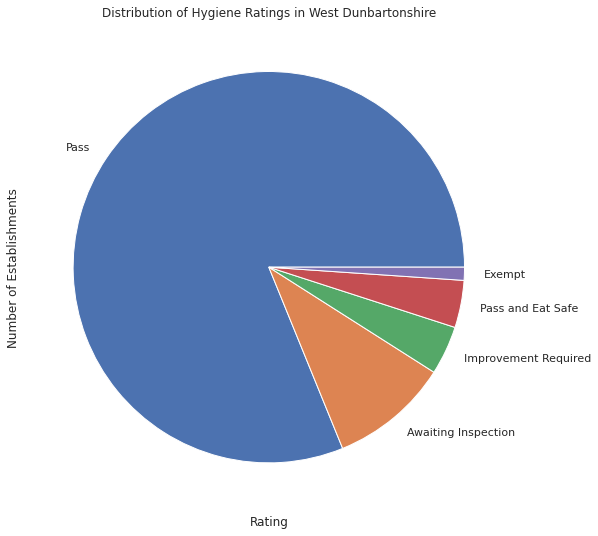

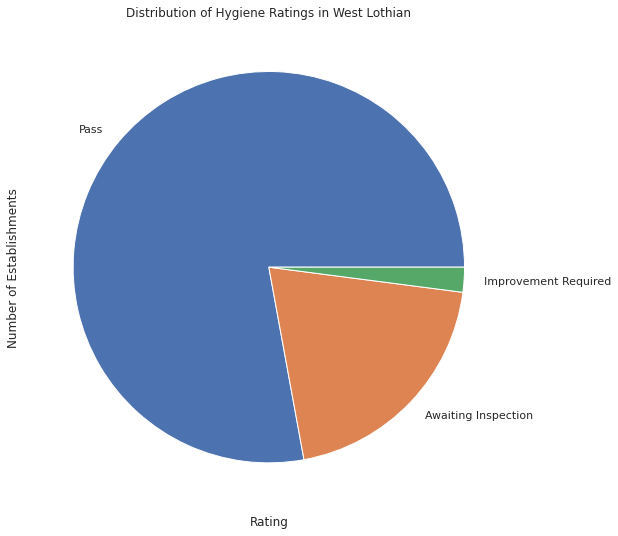

In [4]:
# Get rating value counts
rating_counts = pd.read_sql_query("""
SELECT RatingValue, COUNT(*) as Count
FROM establishments
GROUP BY RatingValue
ORDER BY Count DESC
""", conn)

# Plot
print(rating_counts) # print the data frame
total = rating_counts["Count"].sum()
print("Total counts is: ", total)

rating_counts.plot.pie(y = "Count", labels = rating_counts["RatingValue"], legend = False)
plt.title("Distribution of Hygiene Ratings Scotland-wide")
plt.xlabel("Rating")
plt.ylabel("Number of Establishments")
plt.show()

#Generate a list of local authorities from the master database
local_authorities = pd.read_sql_query("""
SELECT LocalAuthorityCode, LocalAuthorityName
FROM establishments
GROUP BY LocalAuthorityCode
ORDER BY LocalAuthorityName ASC
""",conn)

#Show local authority list
#print(local_authorities)
authorities_list = local_authorities["LocalAuthorityName"].to_list()
print(authorities_list)

master_df = pd.read_sql_query("""
SELECT COUNT(*) as Count, LocalAuthorityName, LocalAuthorityCode, RatingValue
FROM establishments
GROUP BY LocalAuthorityName, RatingValue
ORDER BY Count DESC
""", conn)

#Use a for loop to generate results for each authority
for authority in authorities_list:
    local_df = master_df[master_df["LocalAuthorityName"] == authority]
    local_df.plot.pie(y = "Count", labels = local_df["RatingValue"], legend = False)
    plt.title("Distribution of Hygiene Ratings in " + authority)
    plt.xlabel("Rating")
    plt.ylabel("Number of Establishments")

    plt.show()

## Deep dive into hygiene ratings

We can breakdown the individual ratings to find any correlations between business type and hygiene rating.

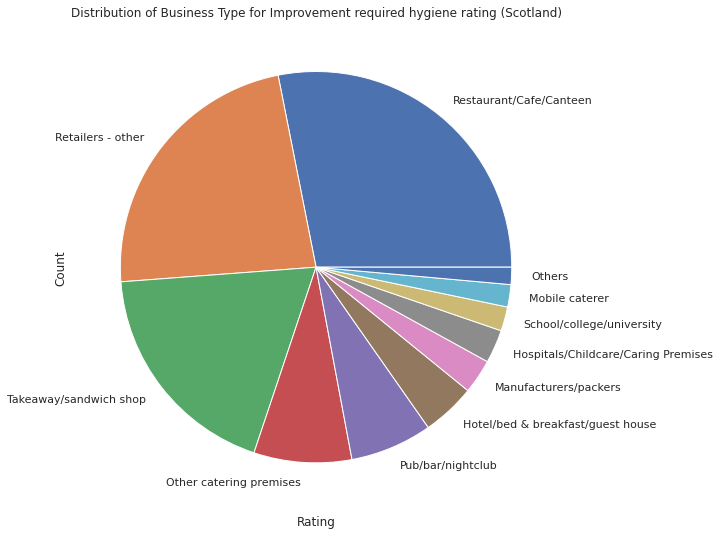

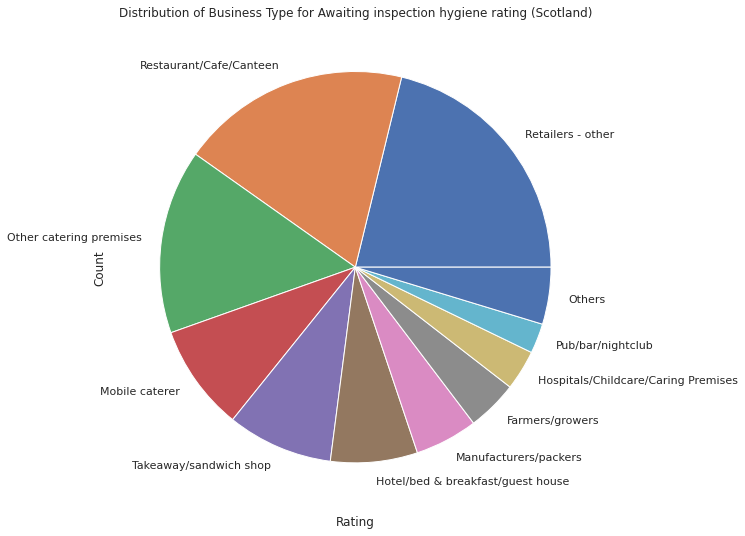

In [5]:
#Get the improvement required ratings along with various parameters
improvement_required = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Improvement Required'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(improvement_required) # print the data frame

#Plotting
improvement_required = topN(improvement_required, 10, "BusinessType") #convertunder top 10 to others
improvement_required.plot.pie(y = "Count", labels = improvement_required["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Improvement required hygiene rating (Scotland)")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

#Get the Exempt ratings along with various parameters
waiting_df = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Awaiting Inspection'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(exempt) # print the data frame

#Plotting
waiting_df = topN(waiting_df, 10, "BusinessType")
waiting_df.plot.pie(y = "Count", labels = waiting_df["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Awaiting inspection hygiene rating (Scotland)")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

# #Show distribution for improvement require by local authority, want this to be a percentage
# local_df = master_df[master_df["RatingValue"] == "Improvement Required"]
# local_df.plot.pie(y = "Count", labels = local_df["LocalAuthorityName"], legend = False)
# plt.title("Distribution of Improvement Required by Authority")
# plt.xlabel("Rating")
# plt.ylabel("Number of Establishments")

Exempt status is granted for businesses that don't produce their own food but do sell pre-packaged products and medicines which is corroborated here: https://essentialfoodhygiene.co.uk/what-are-the-three-food-hygiene-ratings-for-scotland/.

## Businesses by Post Code

Using the intial part of a UK postcode, an indication of geographical area can be found. Lets find how many business fit in these areas.

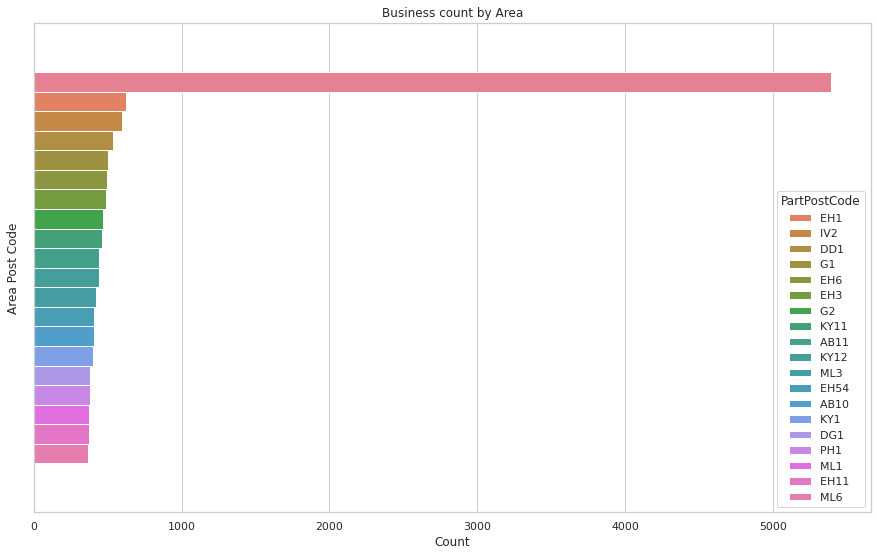

In [6]:
business_by_area = pd.read_sql_query("""
SELECT COUNT(*) as "Number of businesses", SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode
FROM establishments
GROUP BY PartPostCode
ORDER BY "Number of businesses" DESC
LIMIT 20;
""", conn)

#print(business_by_area)
sns.barplot(data=business_by_area, x="Number of businesses", hue="PartPostCode", legend = True)
plt.title("Business count by Area")
plt.xlabel("Count")
plt.ylabel("Area Post Code")
plt.show()



## Map business location data using Geopandas

Using a shapefile for the local authority boundaries from the Improvement Service (license below), the business location data can be placed on a map.

"The dataset is provided under Open Government Licence (OGL) for download and use. You are free to copy, publish, distribute and transmit the information as long as you acknowledge the source as coming from Improvement Service under OGL."

In [ ]:
#Get dataframe
df_geo = pd.read_sql_query("""
SELECT BusinessName, BusinessType, RatingValue, PostCode, SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode, Longitude, Latitude 
FROM establishments;
""", conn)

#Load Scottish local authority boundaries
#Please look at the README file to find instructions on how to download the boundary shapefiles
la_gdf = gpd.read_file("/mnt/d/renfrewshire_business_insights/data/pub_las.shp") #local authority GeoDataFrame

#print(la_gdf.columns.tolist()) #print all available columns in the GeoDataFrame
#print("All available authority names: ") #Check all available authority names
#print(la_gdf["local_auth"].unique())  # Optional: inspect names

#Filter
#high_gdf = la_gdf[la_gdf["local_auth"] == "Highland"].copy()

#Filter out null coordinates from the hygiene dataframe
df_geo = df_geo[df_geo['Latitude'].notnull() & df_geo['Longitude'].notnull()]

#Convert DataFrame to GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo.Longitude.astype(float), df_geo.Latitude.astype(float)),
    crs="EPSG:4326"
)

#Ensure CRS matches
la_gdf = la_gdf.to_crs(epsg=4326)

#Plotting
fig, ax = plt.subplots(figsize=(10, 10))
la_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha = 0.5)
points_gdf.plot(ax=ax, markersize=5, alpha=0.6, color='red')
plt.title("Food Hygiene Establishments in Scotland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

The highlighted area corresponds to Scotland

Before that, we can plot hygiene ratings onto this map as follows.

In [ ]:
##Generate the local authority boundaries to a single GeoDataFrame
#included_areas = ["Highland", "Na h-Eileanan an Iar"]
#boundary_gdf = la_gdf[la_gdf["local_auth"].isin(included_areas)].copy() #boundary dataframe
#boundary_gdf = boundary_gdf.to_crs(epsg=4326) #covnert to consitent CRS

# Map each string rating to a colour
rating_colors = {
    "Pass": "#1a9850",                # green
    "Pass and Eat Safe": "#66bd63",   # light green
    "Improvement Required": "#d73027",# red
    "Awaiting Inspection": "#fdae61", # orange
    "Exempt": "#a6a6a6"               # grey
}

#Create a legend for the plot
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in rating_colors.items()
]

# Map rating to colours by adding a colour column to the dataframe
points_gdf["color"] = points_gdf["RatingValue"].map(rating_colors)

# #Diagnostics
# print(points_gdf[["Longitude", "Latitude", "geometry"]].head())
# print(points_gdf.geom_type.unique())
# print(points_gdf.crs)              

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
la_gdf.plot(ax=ax, color="white", edgecolor="black")
points_gdf.plot(ax=ax, markersize=6, color=points_gdf["color"], alpha=0.8)

plt.title("Highlands Hygiene Ratings by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()


As the vast majority of hygiene ratings were pass, it is expected to see most of the data points be the same colour.

Using `contextily` we can create static map with geographic data to layer under the above plot.

In [ ]:
#Use contextily to plot street map underneath plots
import contextily as ctx

#Reproject both GeoDataFrames to EPSG:3857 (Web Mercator)
points_web = points_gdf.to_crs(epsg=3857)
la_web = la_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

#Plot boundary outline
la_web.plot(ax=ax, color='none', edgecolor='black')
points_web.plot(ax=ax, markersize=6, color=points_web['color'], alpha=0.7) #Plot hygiene points (coloured by rating, as before)

#Add basemap tiles
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) #OpenMap full colour
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) #grayscale overlay

plt.title("Food Hygiene Ratings in Scotland (with Street Map)")
plt.axis("off")
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()

## Interactive map using Folium and GeoPandas

In [32]:
#Redefine the points_web dataframe
df_geo = pd.read_sql_query("""
SELECT BusinessName, BusinessType, RatingValue, PostCode, SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode, 
Longitude, Latitude, LocationApprox
FROM establishments;
""", conn)

# Map each string rating to a colour
rating_colors = {
    "Pass": "#1a9850",                # green
    "Pass and Eat Safe": "#66bd63",   # light green
    "Improvement Required": "#d73027",# red
    "Awaiting Inspection": "#fdae61", # orange
    "Exempt": "#a6a6a6"               # grey
}

#Filter out null coordinates from the hygiene dataframe
df_geo = df_geo[df_geo['Latitude'].notnull() & df_geo['Longitude'].notnull()]
df_geo["LocationApprox"] = df_geo["LocationApprox"].astype(bool) #ensure column is boolean

#Convert DataFrame to GeoDataFrame
points_web = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo.Longitude.astype(float), df_geo.Latitude.astype(float)),
    crs="EPSG:4326"
)

# Map rating to colours by adding a colour column to the dataframe
points_web["color"] = points_web["RatingValue"].map(rating_colors)

points_web = points_web.astype({"Latitude": float, "Longitude": float}) #double check type
points_web = points_web[points_web["RatingValue"] != "Exempt"] #filter out exempt businesses

#Diagnostic - try fewer points
#points_web = points_web[:10000] #first 5000 points
points_web.info()

m = folium.Map(
    location=(55.95, -3.188), #Edinburgh
    zoom_start=7,
    tiles=None
)

#Add tile layer with customer layer name
folium.TileLayer(
    tiles="https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png",
    attr="© OpenStreetMap contributors & CartoDB",
    name="Light map",     #This name appears in the layer control
    control=True,
    show = True
).add_to(m)

#Dark Mode (CartoDB Dark Matter)
folium.TileLayer(
     tiles="https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png",
     name="Dark Map",
     attr="© OpenStreetMap & CartoDB",
     show = False,
).add_to(m)

# #Satellite (Esri World Imagery)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    name="Satellite",     attr="Tiles © Esri",
    show = False
).add_to(m)

#Map an icon specs
rating_icon_specs = {
    "Pass": {"color": "blue", "icon": "check"},
    "Pass and Eat Safe": {"color": "green", "icon": "check"},
    "Improvement Required": {"color": "red", "icon": "exclamation-triangle"},
    "Awaiting Inspection": {"color": "orange", "icon": "clock"},
    "Exempt": {"color": "gray", "icon": "check"}
}

#Add a cluster group for Pass businesses
cluster_layer = folium.FeatureGroup(name="All Businesses (excl. Exempt)", show=True)
marker_cluster = MarkerCluster().add_to(cluster_layer)

# pass_df = points_web[points_web["RatingValue"] == "Pass"] #find the points
# print("Pass info: ")
# pass_df.info()

spec = rating_icon_specs.get("Pass", {"color": "gray", "icon": "info-circle"})
for _, row in points_web.iterrows():
    #Depending on location approximate tag, change popup text
    approx_note = " (approx. location)" if row.get('LocationApprox') else ""
    spec = rating_icon_specs.get(row["RatingValue"], {"color": "gray", "icon": "info-circle"})
    
    popup_text = (
        f"<b>{row['BusinessName']}{approx_note}</b><br>"
        f"Business Type: {row['BusinessType']}<br>"
        f"Rating: {row['RatingValue']}<br>"
        f"Postcode: {row['PostCode']}"
    )   
    folium.Marker( #removed Circle
        location=[row["Latitude"], row["Longitude"]],
        popup=folium.Popup(popup_text, max_width=250),
        icon = folium.Icon(color = spec["color"], icon = spec["icon"], prefix = "fa")
    ).add_to(marker_cluster)

cluster_layer.add_to(m)

#Add a layer highlighting Pass and Eat Safe category
eat_safe_df = points_web[points_web["RatingValue"] == "Pass and Eat Safe"] #find the points
print("Pass and Eat Safe info: ")
eat_safe_df.info()

#Cluster for Pass and Eat Safe category to reduce load
cluster_group = folium.FeatureGroup(name="Pass and Eat Safe", show = False)
cluster = MarkerCluster().add_to(cluster_group)

spec = rating_icon_specs.get("Pass and Eat Safe", {"color": "gray", "icon": "info-circle"})
for _, row in eat_safe_df.iterrows():
    approx_note = " (approx. location)" if row.get('LocationApprox') else ""
    popup_text = (
        f"<b>{row['BusinessName']}{approx_note}</b><br>"
        f"Business Type: {row['BusinessType']}<br>"
        f"Rating: {row['RatingValue']}<br>"
        f"Postcode: {row['PostCode']}"
    )   
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=popup_text,
        icon = folium.Icon(color = spec["color"], icon = spec["icon"], prefix = "fa") #green pass
    ).add_to(cluster)

cluster_group.add_to(m)

# #add a business density heatmap
# heat_data = [[row["Latitude"], row["Longitude"]] for _, row in points_web.iterrows()]
# heat = folium.FeatureGroup(name="Business density heatmap", show = False)
# HeatMap(heat_data, min_opacity=0.4, radius=15).add_to(heat)
# heat.add_to(m)

#Add a layer highlighting Improvement required
improve_df = points_web[points_web["RatingValue"] == "Improvement Required"] #find the points
print("Improvement required info: ")
improve_df.info()

#Cluster for Improvmeent required category to reduce load
cluster_group = folium.FeatureGroup(name="Improvement Required", show = False)
cluster = MarkerCluster().add_to(cluster_group)

spec = rating_icon_specs.get("Improvement Required", {"color": "gray", "icon": "info-circle"})
for _, row in improve_df.iterrows():
    approx_note = " (approx. location)" if row.get('LocationApprox') else ""
    popup_text = (
        f"<b>{row['BusinessName']}{approx_note}</b><br>"
        f"Business Type: {row['BusinessType']}<br>"
        f"Rating: {row['RatingValue']}<br>"
        f"Postcode: {row['PostCode']}"
    )   
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=popup_text,
        icon = folium.Icon(color = spec["color"], icon = spec["icon"], prefix = "fa") #red  warning icon
    ).add_to(cluster)

cluster_group.add_to(m)

#Add a layer highlighting Awaiting inspection
waiting_df = points_web[points_web["RatingValue"] == "Awaiting Inspection"] #find the points
print("Awating inspection info: ")
waiting_df.info()

#Cluster for Awaiting inspections category to reduce load
cluster_group = folium.FeatureGroup(name="Awaiting Inspection", show = False)
cluster = MarkerCluster().add_to(cluster_group)

spec = rating_icon_specs.get("Awaiting Inspection", {"color": "gray", "icon": "info-circle"})
for _, row in waiting_df.iterrows():
    approx_note = " (approx. location)" if row.get('LocationApprox') else ""
    popup_text = (
        f"<b>{row['BusinessName']}{approx_note}</b><br>"
        f"Business Type: {row['BusinessType']}<br>"
        f"Rating: {row['RatingValue']}<br>"
        f"Postcode: {row['PostCode']}"
    )   
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=popup_text,
        icon = folium.Icon(color = spec["color"], icon = spec["icon"], prefix = "fa") #orange clock
    ).add_to(cluster)

cluster_group.add_to(m)

#add an Improvement required heatmap
heat_data = [[row["Latitude"], row["Longitude"]] for _, row in improve_df.iterrows()]
heat = folium.FeatureGroup(name="Improvement required heatmap", show = False)
HeatMap(heat_data, min_opacity=0.4, radius=15).add_to(heat)
heat.add_to(m)

#Add layer control toggle
folium.LayerControl(collapsed = False).add_to(m)

#add sources
m.get_root().html.add_child(folium.Element("""
    <div style="position: fixed; bottom: 5px; left: 5px; font-size: 11px; background-color: white; padding: 4px; border: 1px solid #ccc;">
        Source: <a href='https://ratings.food.gov.uk/open-data/en-GB' target='_blank'>FSA Hygiene Ratings</a>
    </div>
"""))

#Save
m.save("/mnt/d/renfrewshire_business_insights/docs/scotland_hygiene_ratings.html")
#m #show inline

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 49791 entries, 0 to 57058
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   BusinessName    49791 non-null  object  
 1   BusinessType    49791 non-null  object  
 2   RatingValue     49791 non-null  object  
 3   PostCode        49791 non-null  object  
 4   PartPostCode    49791 non-null  object  
 5   Longitude       49791 non-null  float64 
 6   Latitude        49791 non-null  float64 
 7   LocationApprox  49791 non-null  bool    
 8   geometry        49791 non-null  geometry
 9   color           49791 non-null  object  
dtypes: bool(1), float64(2), geometry(1), object(6)
memory usage: 3.8+ MB
Pass and Eat Safe info: 
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 511 entries, 142 to 55924
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   BusinessName    511 non-null

### Outliers

Use the WHERE SQL command to find specific postcodes for outlier analysis.

In [ ]:
outliers = pd.read_sql_query("""
SELECT BusinessName, BusinessType, PostCode, AddressLine1,
AddressLine2, AddressLine3, AddressLine4
FROM establishments
WHERE PostCode LIKE "G%" OR PostCode LIKE "A%";
""", conn)

outliers.head()

Two of the results are mobile caterers which could explain the lack of a business address within the confines of Renfrewshire. 

## Tableau conversion

In [ ]:
#Convert points GeoDataFrame to csv
#points_web.drop(columns="geometry").to_csv("/mnt/d/renfrewshire_business_insights/data/establishments_clean.csv", index = False)

## Conclusions ##

“This analysis explored food hygiene trends in the Highlands using publicly available inspection data, geospatial mapping, and simulated Yelp enrichment. It demonstrates core data skills including SQL, Python, spatial joins, and visual communication.”

## Save and Close

In [ ]:
conn.close()